# Mask2Coco

In this notebook, I am experimenting with converting a Mask Image into the Coco formatted json file for use with the Mask RCNN framework for Image Segmentation. As such I am going to use the [Lungs in CT dataset](https://www.kaggle.com/kmader/finding-lungs-in-ct-data) downloaded from Kaggle.

I will be using skimage and imantics library for data manipulation.

The LungCT dataset is noisy, so I have modified most of the masks to be consistent.

If you get errors while running this notebook, you have to go back and modify the mask images. Alternatively, you can modify the code below to suit your particular needs.

In [1]:
from pathlib import Path
import glob
import os

from skimage.io import imread
import matplotlib.pyplot as plt


In [2]:
# Set base parameters 
BASE_IMG_PATH = Path('D:/datasets/CT_images_segmented_lungs/')

# Read .tif files
all_image_files = glob.glob(os.path.join(BASE_IMG_PATH,'2d_images','*.tif'))
print(all_image_files[0])

# Iterate over each and save in jpg format for use with Mask RCNN model
for i in all_image_files:
    img = imread(i)
    plt.imsave(i[:-19]+'_jpg'+i[-19:-4]+'.jpg', img, cmap = plt.cm.gray)


D:\datasets\CT_images_segmented_lungs\2d_images\ID_0000_Z_0142.tif


In [4]:
# Read all Image jpg files and the corresponding Mask tif files

all_image_files = glob.glob(os.path.join(BASE_IMG_PATH,'2d_images_jpg','*.jpg'))
all_mask_files  = glob.glob(os.path.join(BASE_IMG_PATH,'2d_masks','*.tif'))

print('No. of images:', len(all_image_files))
print(all_image_files[0])
print(all_mask_files[0])


No. of images: 267
D:\datasets\CT_images_segmented_lungs\2d_images_jpg\ID_0000_Z_0142.jpg
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0000_Z_0142.tif


To use the imantics library, we can simply <b>pip install imantics</b>

For more API related information, please check out their [official docs](https://imantics.readthedocs.io/en/latest/index.html).

Test the library on a single input image/mask and understand how to utilize it.

When we calculate the polygons, the library looks for intensity changes (binary masks) and returns the pixels corresponding to the change.

There are some masks in Lung CT dataset, which needed to be edited beforehand to maintain the consistency across each masks, such that each mask has a left_lung and a right_lung, and some might have multiple inner polygons which I am referring to as unidentified.

In [5]:
# Import the useful modules from imantics library
from imantics import Polygons, Mask, Image, Category

# Input any image/mask
IMG_INDEX = 7

img_path, mask_path = all_image_files[IMG_INDEX], all_mask_files[IMG_INDEX]
print(img_path)

# Read the image and the corresponding mask
image = Image.from_path(img_path)
mask = imread(mask_path)

# For the edited masks (edited using Paint 3D), 
# the shape increases to 3-dimension (no changes to the mask itself just 3rd dimension is added)
# Mask from imantics needs the mask to be in 2-dimension

if len(mask.shape) > 2:    mask_array = Mask(mask[:,:,0])
else:                      mask_array = Mask(mask)

# Calculate the polygons in the mask, this returns all the polygons in the mask in both points and segmentation format.
# For lungCT masks, this will return the left lung, right lung and the missing inner parts.
polygons = mask_array.polygons()

print(len(polygons.points))

D:\datasets\CT_images_segmented_lungs\2d_images_jpg\ID_0007_Z_0211.jpg
3


Here we see for image_id 7 we have three polygons corresponding to each class we have defined.

To validate the polygons are infact the corresponding classes, we can make use of the skimage library as seen below

Text(0.5, 1.0, 'Mask')

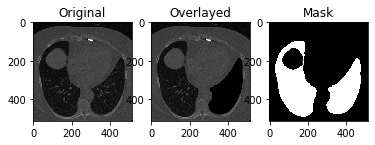

In [6]:
# Skimage.draw's polygon calculate all the pixels that lie inside a given polygon
from skimage.draw import polygon

P_INDEX = 0

fig, (ax1 ,ax2, ax3) = plt.subplots(1, 3)
img = imread(all_image_files[IMG_INDEX])
ax1.imshow(img, cmap='gray')
ax1.set_title('Original')

# For a calculated polygon, we can simply index into the polygons array and fill the polygon region
c = polygons.segmentation[P_INDEX][::2]
r = polygons.segmentation[P_INDEX][1::2]
rr, cc = polygon(r, c)
img[rr, cc] = 1

#Show the filled polygon and corresponding mask
ax2.imshow(img, cmap='gray')
ax2.set_title('Overlayed')
ax3.imshow(mask)
ax3.set_title('Mask')

We can see that the P_INDEX=0 for IMG_INDEX=7 is the right_lung

One thing of notice is that, there is no order on how the polygons are calculated. So we cannot directly go ahead and label the polygons to the classes.

Below I have created a basic intuition based logic to handle this. Note that this will only apply to the current dataset.

Finally I am applying this to all the data in my dataset (then I will separate them into train, validation and test sets).

In [7]:
# Import the useful modules from imantics library
from imantics import Polygons, Mask, Image, Category

for i in range(len(all_image_files)):
    
    # The intial few lines are same as before as we are calculating the polygons in the mask
    img_path, mask_path = all_image_files[i], all_mask_files[i]
    
    image = Image.from_path(img_path)
    mask = imread(mask_path)
    print(mask_path)
    
    if len(mask.shape) > 2:        mask_array = Mask(mask[:,:,0])
    else:                          mask_array = Mask(mask)
    
        
    polygons = mask_array.polygons()

    # Given that right lung should be on the right side of the image,
    # the x-coordinate for that polygon should be greater than half the size of image in x-direction
    # IMG size is 512 by 512

    # So, here I loop over each polygon and for each polygon, 
    # I store the count of x-coordinate values greater than 256 in a dictionary,
    # where the key is in the following format (for future use):
    #         <index in polygons array>_<length/number of the polygons.points>

    
    x_counter = {}                                       # Dictionary to store the key:count pair
    for j,p in enumerate(polygons.points):               # Loop over each polygon
        count = 0                                        # Intialize counter to zero
        for a in p:
            if a[0] > 256:     count += 1     # Check the x-coordinate [0-index] for each point in the polygon
        x_counter[str(j)+'_'+str(len(p))] = count        # Store the count along with additional info in the key
    
    # Let's start labeling
    # For unidentified class, I had to iterate through all images 
    # and figure out the maximum length of polygons.points. That's what will allow us to label this class.
    
    keys_d = []                                          # To store the keys which are being labeled
    for k, v in x_counter.items():                          # Loop over key:count pair on the dictionary created in the last step
        p_index, p_len = k.split('_')                    # Split the key and save the index and length of the polygon
        if int(p_len) < 120:                             # For the LungCT dataset, the maximum length was around 115, using 120
            # For any polygon with length smaller than 120 we add the label unidentified
            image.add(Polygons(polygons.points[int(p_index)]), category=Category("unidentified"))

            keys_d.append(k)                             # Store the key

    # For Right Lung, we know that the x-coordinate of the points in the polygons should lie in the right side of the mask,
    # We have already calculated the count for each polygon, so the one with maximum value sould correspong to right_lung.
    
    max_key = max(x_counter, key = x_counter.get)        # Get the key with the maximum value
    p_index = int(max_key.split('_')[0])                 # Split the key and get the index
    # Add the polygon at that index with the label right_lung
    image.add(Polygons(polygons.points[p_index]), category=Category("right_lung"))

    keys_d.append(max_key)                               # Store the key

    # We could apply the similar logic to identify the polygon for the left lung,
    # but as I only have three classes and I should have one and only one polygon for left lung
    # so I can go ahead and find the only key which is still unlabeled and use that directly.
    
    # Find the key which is not yet label and split it to get the index
    p_index = [int(k.split('_')[0]) for k in x_counter.keys() if k not in keys_d]
    
    if len(p_index) == 1:                                # should be one and only one left lung
                                                         # handles the case for one mask with no left lung mask
        # Add the polygon at that index with the label left_lung
        image.add(Polygons(polygons.points[p_index[0]]), category=Category("left_lung"))

    # Go ahead and save the image in coco style with a same image name but with .json extension
    image.save(img_path[:-4]+'.json', style='coco')

D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0000_Z_0142.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0001_Z_0146.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0002_Z_0162.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0003_Z_0132.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0004_Z_0066.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0005_Z_0066.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0006_Z_0206.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0007_Z_0211.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0008_Z_0065.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0009_Z_0114.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0010_Z_0259.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0011_Z_0156.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0012_Z_0167.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0013_Z_0047.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0014_Z_0116.tif
D:\dataset

C:\Users\Z0044XNH\AppData\Local\Continuum\anaconda3\envs\tensorflow2\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0065_Z_0126.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0066_Z_0141.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0067_Z_0238.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0068_Z_0055.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0069_Z_0054.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0070_Z_0120.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0071_Z_0072.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0072_Z_0119.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0073_Z_0076.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0074_Z_0066.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0075_Z_0061.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0076_Z_0230.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0077_Z_0173.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0078_Z_0058.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0079_Z_0202.tif
D:\dataset

D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0190_Z_0070.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0191_Z_0140.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0192_Z_0064.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0193_Z_0060.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0194_Z_0120.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0195_Z_0062.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0196_Z_0259.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0197_Z_0123.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0198_Z_0120.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0199_Z_0119.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0200_Z_0125.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0201_Z_0241.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0202_Z_0098.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0203_Z_0079.tif
D:\datasets\CT_images_segmented_lungs\2d_masks\ID_0204_Z_0066.tif
D:\dataset

Here I have not abstracted the repetitive actions as this was just an experiment and learning notebook.

Modify this notebook as necessary for yourselves.